In [ ]:
from google.colab import drive

In [ ]:
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import string
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from imblearn.combine import SMOTEENN
from imblearn.under_sampling import EditedNearestNeighbours
from imblearn.over_sampling import SMOTE,RandomOverSampler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split,KFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB
from sklearn.svm import SVC
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from textblob import TextBlob
from ipywidgets import interact,interact_manual
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

In [ ]:
data=pd.read_csv("/content/drive/MyDrive/datasets/Reviews.csv")
data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...


In [ ]:
pd.DataFrame({"dtypes":data.dtypes,"Missing":data.isnull().sum(),"Size":data.shape[0]}).style.background_gradient(cmap="Blues")

,dtypes,Missing,Size
Id,int64,0,568454
ProductId,object,0,568454
UserId,object,0,568454
ProfileName,object,16,568454
HelpfulnessNumerator,int64,0,568454
HelpfulnessDenominator,int64,0,568454
Score,int64,0,568454
Time,int64,0,568454
Summary,object,27,568454
Text,object,0,568454


In [ ]:
data.dropna(inplace=True)

In [ ]:
data.describe().style.background_gradient(cmap="inferno")

,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
count,568411.000000,568411.000000,568411.000000,568411.000000,568411.000000
mean,284227.440964,1.743874,2.227876,4.183309,1296261292.925014
std,164099.020907,7.636781,8.288752,1.310368,48037915.845108
min,1.000000,0.000000,0.000000,1.000000,939340800.000000
25%,142114.500000,0.000000,0.000000,4.000000,1271289600.000000
50%,284224.000000,0.000000,1.000000,5.000000,1311120000.000000
75%,426341.500000,2.000000,2.000000,5.000000,1332720000.000000
max,568454.000000,866.000000,923.000000,5.000000,1351209600.000000


## simpl Feature Extraction 

In [ ]:
data["Helpfulnesspercentage"]=np.where(data["HelpfulnessDenominator"]>0,data["HelpfulnessNumerator"]/data["HelpfulnessDenominator"],-1)

In [ ]:
def get_bins(x):
  if x<0:
    return "empty"
  if x>=0 and x<=0.2:
    return "0-20%"
  if x>0.2 and x<=0.4:
    return "20-40%"
  if x>0.4 and x<=0.6:
    return "40-60%"
  if x>0.6 and x<=0.8:
    return "60-80%"
  if x>0.8 and x<=1:
    return "80-100%"
data["Helpfulnessbins"]=data["Helpfulnesspercentage"].apply(get_bins)

In [ ]:
data.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulnesspercentage,Helpfulnessbins
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,1.0,80-100%
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,-1.0,empty
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,1.0,80-100%
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,1.0,80-100%
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,-1.0,empty


## Exploratory Data Analysis

In [ ]:
data.dropna(inplace=True)

In [ ]:
@interact
def get_(Helpfulnessbins=data["Helpfulnessbins"].unique()):
  return data[data["Helpfulnessbins"]==Helpfulnessbins][["ProfileName","HelpfulnessNumerator","Summary","HelpfulnessDenominator","Score",
          "Helpfulnesspercentage","Time",]].sort_values(by="Score",
                                                  ascending=False).head(10).style.background_gradient(cmap="hot")

interactive(children=(Dropdown(description='Helpfulnessbins', options=('80-100%', 'empty', '60-80%', '0-20%', …

## Top ten Products

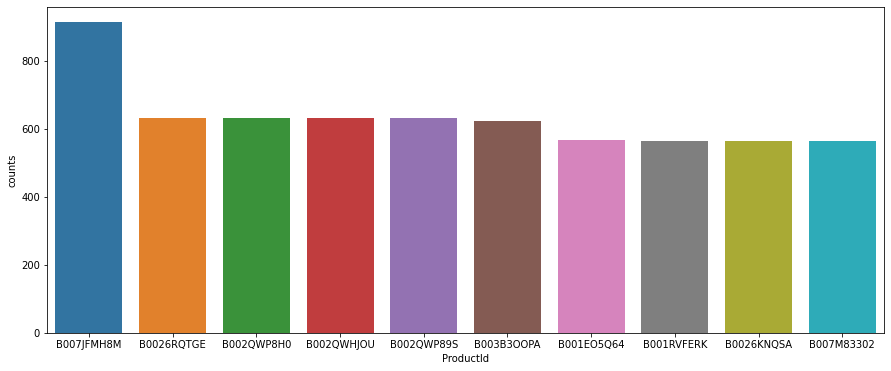

In [ ]:
df=data.groupby("ProductId").agg({"HelpfulnessNumerator":"mean","HelpfulnessDenominator":"mean",
                                    "Helpfulnessbins":','.join,"ProfileName":';'.join,"Score":"mean",
                                             "Helpfulnesspercentage":"mean"})
df=df.reset_index()
df["counts"]=df["Helpfulnessbins"].apply(lambda x: len(x.split(",")))
df=df.sort_values(by="counts",ascending=False)[["ProductId","HelpfulnessNumerator","counts","HelpfulnessDenominator","Helpfulnesspercentage","Score"]].head(10)
plt.rcParams["figure.figsize"]=(15,6)
sns.barplot(df["ProductId"][:10],df["counts"][:10],orient="v")
plt.show()

In [ ]:
df.head()

,ProductId,HelpfulnessNumerator,counts,HelpfulnessDenominator,Helpfulnesspercentage,Score
71170,B007JFMH8M,0.044907,913,0.050383,-0.933370,4.582694
37898,B0026RQTGE,0.966772,632,1.403481,-0.501016,4.588608
42264,B002QWP8H0,0.966772,632,1.403481,-0.501016,4.588608
42257,B002QWHJOU,0.966772,632,1.403481,-0.501016,4.588608
42263,B002QWP89S,0.966772,632,1.403481,-0.501016,4.588608


## Information with respect to No of products sells (counts)

In [ ]:
@interact
def get_(counts=1000):
   return df[df["counts"]<=counts].head(10).style.background_gradient(cmap="hot")

interactive(children=(IntSlider(value=1000, description='counts', max=3000, min=-1000), Output()), _dom_classe…

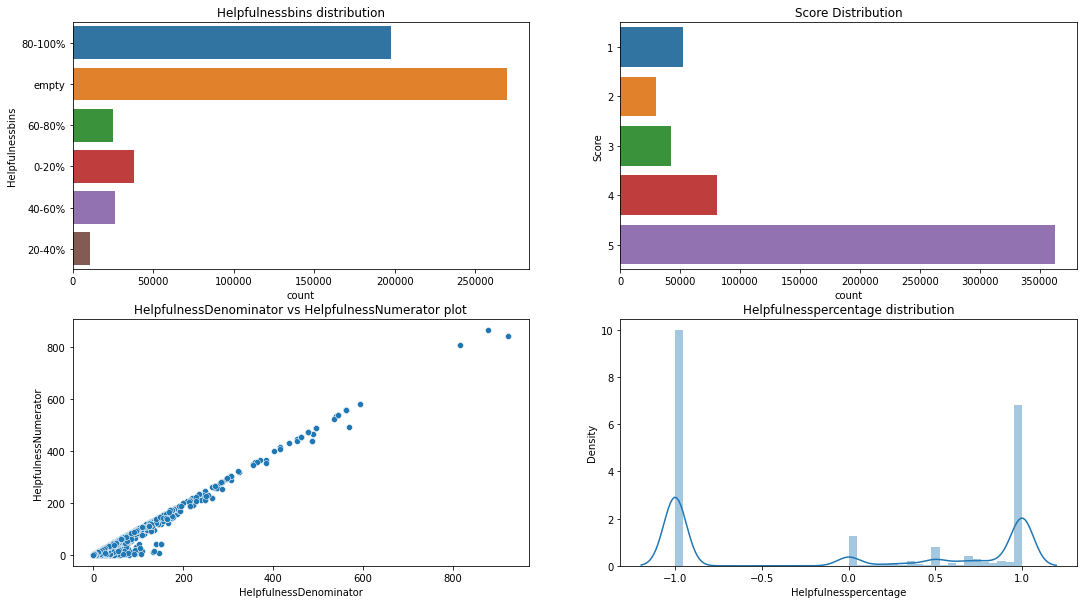

In [ ]:
plt.rcParams["figure.figsize"]=(18,10)
plt.subplot(2,2,1)
sns.countplot(y=data["Helpfulnessbins"],orient="v")
plt.title("Helpfulnessbins distribution")
plt.subplot(2,2,2)
sns.countplot(y=data["Score"],orient="v")
plt.title("Score Distribution")
plt.subplot(2,2,3)
sns.scatterplot(data["HelpfulnessDenominator"],data["HelpfulnessNumerator"])
plt.title("HelpfulnessDenominator vs HelpfulnessNumerator plot")
plt.subplot(2,2,4)
sns.distplot(data["Helpfulnesspercentage"])
plt.title("Helpfulnesspercentage distribution")
plt.show()

## Cleaning the Text Data

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [ ]:
data=data.iloc[:5000,:]

In [ ]:
def get_filter(sent):
  punc_filtered=[]
  for ch in sent:
    if ch not in string.punctuation:
      punc_filtered.append(ch)
  punc_filtered=''.join(punc_filtered)
  punc_lower_filtered=[]
  for word in nltk.tokenize.word_tokenize(punc_filtered):
    punc_lower_filtered.append(word.lower())
  punc_lower_filtered=' '.join(punc_lower_filtered)
  punc_lower_stw_filtered=[]
  for word in nltk.tokenize.word_tokenize(punc_lower_filtered):
    if word not in nltk.corpus.stopwords.words("english"):
      punc_lower_stw_filtered.append(word)
  punc_lower_stw_filtered=' '.join(punc_lower_stw_filtered)
  punc_lower_stw_lemetz_filtered=[]
  for word in nltk.tokenize.word_tokenize(punc_lower_stw_filtered):
    punc_lower_stw_lemetz_filtered.append(nltk.stem.wordnet.WordNetLemmatizer().lemmatize(word))
  punc_lower_stw_lemetz_filtered=' '.join(punc_lower_stw_lemetz_filtered)
  return punc_lower_stw_lemetz_filtered

%time data["Text"]=data["Text"].apply(get_filter)

CPU times: user 45.8 s, sys: 4.22 s, total: 50.1 s
Wall time: 50.1 s


(<matplotlib.image.AxesImage at 0x7f2af2e24bd0>,)

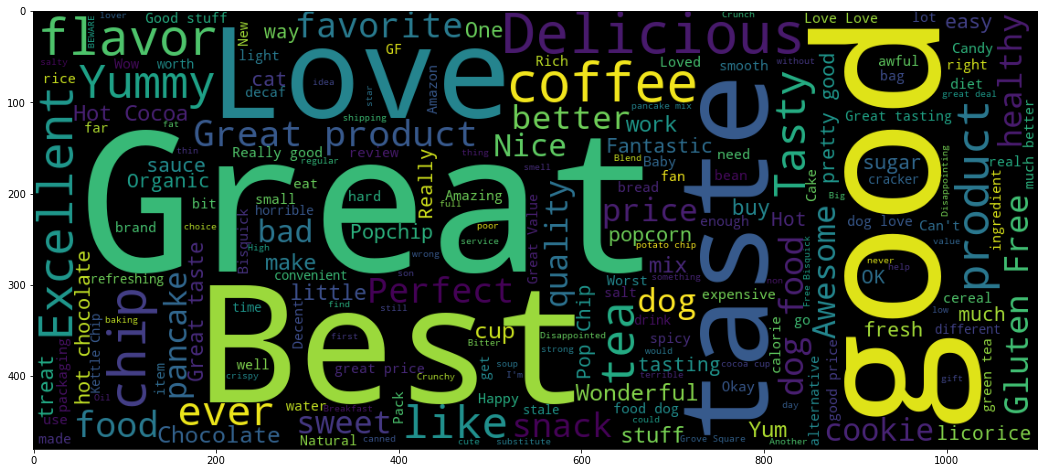

In [ ]:
plt.imshow(WordCloud(width=1100,height=480,stopwords=set(nltk.corpus.stopwords.words("english"))).generate(' '.join(data["Summary"]))),

## Creating New Features

In [ ]:
def get_sentiment(x,check):
  if check=="polarity":
    return TextBlob(x).sentiment.polarity
  if check=="subjectivity":
    return TextBlob(x).sentiment.subjectivity

for i in ["polarity","subjectivity"]:
  data[i]=data["Text"].apply(lambda x: get_sentiment(x,i))

In [ ]:
data.head(2)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Helpfulnesspercentage,Helpfulnessbins,polarity,subjectivity
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,bought several vitality canned dog food produc...,1.0,80-100%,0.425000,0.400000
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,product arrived labeled jumbo salted peanutsth...,-1.0,empty,0.216667,0.762963


## with respect to Hlpfullness probabily 

In [ ]:
@interact
def get_(Helpfulness=data["Helpfulnessbins"].unique()):
  return data[data["Helpfulnessbins"]==Helpfulness][data.drop(columns=["Id","ProductId","UserId",
                               "HelpfulnessNumerator","HelpfulnessDenominator","Text","Helpfulnesspercentage"]).columns].sort_values(by="Score",
                                                      ascending=False).head(10).style.background_gradient(cmap="hot")

interactive(children=(Dropdown(description='Helpfulness', options=('80-100%', 'empty', '60-80%', '0-20%', '40-…

## Data wrt the sentiment of sentance and in helpfullness probability range

In [ ]:
@interact
def get_(Helpfulness=data["Helpfulnessbins"].unique(),polarity=0.45):
  df=data[(data["Helpfulnessbins"]==Helpfulness) & (data["polarity"]<=polarity)][data.drop(columns=["Id","ProductId","UserId","ProfileName"]).columns]
  plt.rcParams["figure.figsize"]=(16,10)
  return (
      plt.subplot(2,2,1),
      sns.countplot(y=df["Score"],orient="v"),
      plt.title("distribution of Score"),
      plt.subplot(2,2,2),
      sns.distplot(df["polarity"]),
      plt.title("distribution of polarity"),
      plt.subplot(2,2,3),
      plt.imshow(WordCloud(width=900,height=650,stopwords=set(nltk.corpus.stopwords.words("english"))).generate(' '.join(df["Text"]))),
      plt.title("Word Cloud"),
      plt.subplot(2,2,4),
      sns.scatterplot(df["polarity"],df["subjectivity"]),
      plt.title("polarity vs subjectivity graph"),
      plt.show()
  )
                                                     

interactive(children=(Dropdown(description='Helpfulness', options=('80-100%', 'empty', '60-80%', '0-20%', '40-…

## Counts everything on the basis of Score and helpfulness probability range

In [ ]:
data.groupby(["Score","Helpfulnessbins"]).agg("count").head(16).style.background_gradient(cmap="Blues")

## Find all the trending words with different sentiments and score

In [ ]:
@interact
def get_(subjectivity=0.45,polarity=0.45,Score=data["Score"].unique()):
  df=data[(data["subjectivity"]<=subjectivity) & (data["polarity"]<=polarity) & (data["Score"]<=Score)][data.drop(columns=["Id","ProductId","UserId","ProfileName"]).columns]
  plt.rcParams["figure.figsize"]=(20,6)
  return (
      plt.imshow(WordCloud(width=1100,height=420,stopwords=set(nltk.corpus.stopwords.words("english"))).generate(' '.join(df["Text"]))),
      plt.title("Word Cloud"),
      plt.show()
  )
                                                     


interactive(children=(FloatSlider(value=0.45, description='subjectivity', max=1.35, min=-0.45), FloatSlider(va…

## No of Users With each Score

In [ ]:
data.groupby(["Score","Helpfulnessbins"]).agg({"UserId":"count"}).sort_values(by="UserId",ascending=False).head(16).style.background_gradient(cmap="hot")

In [ ]:
df=data.groupby(["Score","Helpfulnessbins"]).agg({"UserId":"count"}).reset_index()

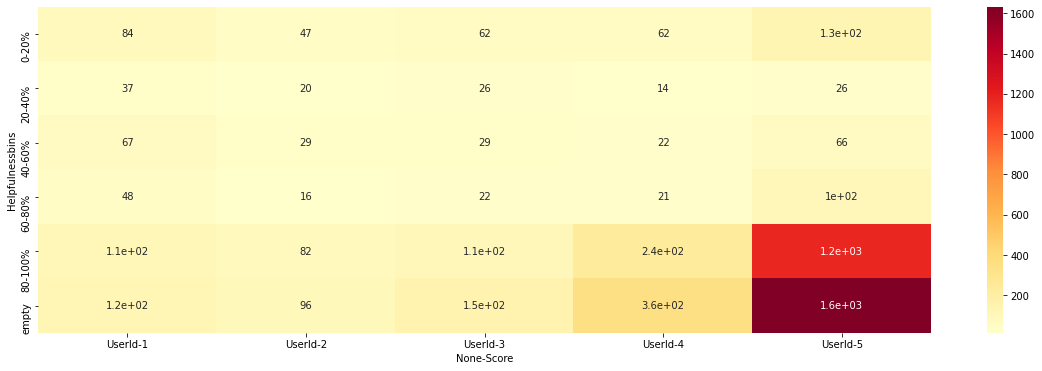

In [ ]:
sns.heatmap(pd.pivot_table(df,index="Helpfulnessbins", columns="Score"),annot=True,cmap="YlOrRd")

In [ ]:
data["Score"].unique()

array([5, 1, 4, 2, 3])

## Because 3 is Neutral Score

In [ ]:
data=data[data["Score"]!=3]
data["Score"]=data["Score"].map({1:0,2:0,4:1,5:1})

In [ ]:
data["Score"].unique()

array([1, 0])

In [ ]:
data.shape

(4605, 14)

In [ ]:
data["Score"].value_counts()

1    3846
0     759
Name: Score, dtype: int64

## Model Building

In [ ]:
x=CountVectorizer().fit_transform(data["Text"]).toarray()
y=data["Score"].values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
model=LogisticRegression()
model.fit(x_train,y_train)
print(model.score(x_test,y_test))
print(classification_report(y_test,model.predict(x_test)))

0.8925081433224755
              precision    recall  f1-score   support

           0       0.75      0.50      0.60       149
           1       0.91      0.97      0.94       772

    accuracy                           0.89       921
   macro avg       0.83      0.74      0.77       921
weighted avg       0.88      0.89      0.88       921



## After Balancing the DATA

In [ ]:
x=CountVectorizer().fit_transform(data["Text"]).toarray()
y=data["Score"].values
re_x,re_y=SMOTEENN().fit_sample(x,y)
x_train,x_test,y_train,y_test=train_test_split(re_x,re_y,test_size=0.2)
model=LogisticRegression()
model.fit(x_train,y_train)
print(model.score(x_test,y_test))
print(classification_report(y_test,model.predict(x_test)))

0.9860759493670886
              precision    recall  f1-score   support

           0       0.99      0.99      0.99       772
           1       0.73      0.61      0.67        18

    accuracy                           0.99       790
   macro avg       0.86      0.80      0.83       790
weighted avg       0.99      0.99      0.99       790



## With TF-IDF without balancing

In [ ]:
x=TfidfVectorizer().fit_transform(data["Text"]).toarray()
y=data["Score"].values
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)
model=LogisticRegression()
model.fit(x_train,y_train)
print(model.score(x_test,y_test))
print(classification_report(y_test,model.predict(x_test)))

0.8588490770901195
              precision    recall  f1-score   support

           0       1.00      0.12      0.22       148
           1       0.86      1.00      0.92       773

    accuracy                           0.86       921
   macro avg       0.93      0.56      0.57       921
weighted avg       0.88      0.86      0.81       921



## Interactive Output 
### (we use balance technique in function but no need to Balanced because we use KFolds so data is changing and not remain imbalanced any more)

In [ ]:
@interact_manual
def apply(Model=[LogisticRegression(),RandomForestClassifier(),MultinomialNB(),GaussianNB(),SVC()],
                vectorizer=[CountVectorizer(),TfidfVectorizer()],advance=["Simple","Balanced"],Balncing=[SMOTEENN(),
                                                        SMOTE(),EditedNearestNeighbours(),RandomOverSampler()]):
  result=[]
  x=vectorizer.fit_transform(data["Text"]).toarray()
  y=data["Score"].values
  if advance=="Balanced":
    x,y=Balncing.fit_sample(x,y)
  for train_ind,test_ind in KFold(4).split(x):
    x_train,x_test,y_train,y_test=x[train_ind],x[test_ind],y[train_ind],y[test_ind]
    model=Model
    model.fit(x_train,y_train)
    result.append(model.score(x_test,y_test))
  pred=model.predict(x_test)
  plt.rcParams["figure.figsize"]=(15,6)
  return (
      print(f'Accuracy is : {pd.Series(result).mean()}'), print(f'All folds result are {result}'),
      print("REPORT : ") , print(classification_report(y_test,model.predict(x_test))),
      plt.subplot(1,2,1) , sns.countplot(y_test) , plt.title("Original"),
      plt.subplot(1,2,2) , sns.countplot(pred) , plt.title("Predicted"),
      plt.show()
  )
  


interactive(children=(Dropdown(description='Model', options=(LogisticRegression(C=1.0, class_weight=None, dual…

The Above Function Take Lot of Time Because it use
### 1. Vectorizer Technique (Countvectorizer or Tf-IDF Vectorizer)
### 2. Technique for balancing (SMOTEENN, SMOTE, ENN, Ramdomizesampler and others)
### 3. KFold Technique for Better result (use 4 Fold)
### 4. Machine learning Model Building 
### 5. Showing All the Result (accuracy,report and graphs)
# We use Picke object saving concept to minimize the time taken by function